<img src="https://www.overstory.ai/wp-content/uploads/2020/08/OVERSTORY_LOGO_BLACK_CMYK.png" alt="Overstory" width="200"/>

# Devops Candidate Assignment: Cloud Cover Segmentation on Kubernetes


Dear potential future devops engineer!
At Overstory we work with large volumes of satellite data, which is challenging for training our machine learning models, as well as running predictions on areas that can be as large as an entire country (millions of pixels!).

On the infra side:
- we recently moved from AWS to GCP (follow the free credits!)
- data-science happens mainly in jupyter notebooks with some extra tooling to be able to compile notebooks into proper python libraries, as well as unit tests running as Github Actions, auto-stripping of notebooks for proper git sanity (PRs, code reviews, diffs, etc) tand auto-generated documentation. See also: https://medium.com/overstoryai/how-nbdev-helps-us-structure-our-data-science-workflow-in-jupyter-notebooks-9cf6081b051f
- We're using jupyterlab to access notebooks easily, as well as having multiple custom environments and machien types (cpu, memory, cuda, persitent and non persistent) available, with user configs, custom gcs and gfs endpoints etc. All to make the work of our data-scientists more fun and productive!
- ETL (ingesting satellite data), is done through dockerized containers that we're moving to a more kubernetes capable solution
- all infrastructure runs as infra-as-code using terraform, making it more easy to test and maintain, as well as move to other cloud providers
- ML models are maintained with custom tooling, for which we use pytorch and fast.ai which we heavily adapted to use with satellite type data. In the future we will be adding more experiment tracking, model versioning, etc using MLflow, weights&biases, Kubeflow, etc
- Infra-wise we take a lot of inspiration from the Pangeo OSS project  (primarily Jupyter Hub, Dask, Xarray, Zarr, and HDF5 file formats)
- More info on the dev ops specific work can also be found at the job posting at https://angel.co/company/overstoryai/jobs/924534-senior-dev-ops


----

# ASSIGNMENT

For your assignment we'd want you to setup a basic scalable and testable kubernetes based environment:
- 1. Use the starter code below and create a web service in python (eg use flask), define and build a docker image and push it to a public registry

It should expose one endpoint that should make easy to run the function `utils.infer_image()` 

The only argument we are interested in is `image_path`.

The app will only get a 512x512 image send to it. There's some code below to take a crop from a full satelite tile. It is only there for you to have data to test things out.

An entire satellite image will be way too large to send as a server request (theres a bunch of interesting challenges here infra-wise which we kept out of the assignment), so you're expected to be able to send and predict for a 512x512 satellite patch with 10 bands (channels)

return should be a numpy array that is returned from the function


- 2. Deploy the ML service it as a containerised ML Model to Kubernetes
- 3. Stretch goal: Set things up a Multi-Node Cluster locally or on the Google Cloud Platform


You are to deliver this as a github project with all config files ready to run and test for us, or just zip it all up and email it to roelof@overstory.ai

Note: you can run kubernetes locally using minikube: https://kubernetes.io/docs/setup/learning-environment/minikube/


Thing we will pay attention to:
- all steps taken are well documented and we are able to reproduce things easily, eg using terraform is a plus
- all services are tested, command outputs are documented (preferably run from a jupyter notebook to keep track of commands and outputs, as well as documentation)
- performance of running the model is tested: whats the max i/o / predictions/sec we can make, and how would we scale this up? So the performance of the endpoint.


# The Data

*(not nescesarry to read, only if you'd like to know more about the data you work with)*

Sentinel-2 (the data we're using) has 11 bands/channels! For ease here's a snippet that lets you just load the rgb, and near infrared channels. For an overview of all channels see https://en.wikipedia.org/wiki/Sentinel-2.

Since a single image is about 10980 x 10980 pixels, you will want to cut this up into smaller images, before training on them. We'll leave this for you to figure out :)

You will use rasterio, as a library to load a multi band tif file. We have made a couple of tiles available on our public s3.

For example there is the file `Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%.tif` which means that its a Sentinel product `2L2A`, a particular enrichment level we don't care much about for the moment. It has been preprocessed usinf `sen2cor`: also not something we care for atm. The tile_id, _is_ something we care for, `58KFC` in this case (No not for Kentucky Fried Chicken), and then the date `2018-20-21`  which is what we care for when there are multiple tiles with the same tile_id, as an image of the earth is unique by `location`  and by `time`. So the tile_id + the date will be the unique identifier. Further we can see that a rough estimation of the percent of clouds is 1.2% and that the Sentinel2 satellite has managed to take an image of the whole area (If there are missing values, they tend to be set to a value of `255`  for `no_data`)

Similarly you can find another tif file called `cloud_mask_58KFC_20181021_clouds=5%.tif`. That's the matching labels we want to learn. They're not perfect as they're automatically created, but they're sufficient for this example. Here we can see that the `tile_id` is the same: `58KFC`, and the date the same as the above input tile as well: `2018-20-21`. The clouds as estimated by an out of the box cloud detection classifier (which should be easy to outperform, even from this rough data you're training on), it estimates that 5% of the image are actually clouds (versus the sentinel2 - similarly not very good - cloud detection model estimates 1.2%).


Example pairs of tile and mask:
![ex1](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex1.png)
![ex2](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex2.png)
![ex3](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex3.png)

Note that for this assignment we're only interested in the input satellite image and not the labels !!!


In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 1.4 MB/s 


In [ ]:
# thrown together library in one messy file and a pytorch model checkpoint :)
!wget https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/utils.py
!wget https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/live_model.pickle

--2022-12-23 16:26:55--  https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/utils.py
Resolving 20tree-public.s3-eu-west-1.amazonaws.com (20tree-public.s3-eu-west-1.amazonaws.com)... 52.218.91.16, 3.5.70.193, 52.92.34.26, ...
Connecting to 20tree-public.s3-eu-west-1.amazonaws.com (20tree-public.s3-eu-west-1.amazonaws.com)|52.218.91.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14837 (14K) [text/x-python-script]
Saving to: ‘utils.py’

utils.py            100%[===================>]  14.49K  --.-KB/s    in 0s      

2022-12-23 16:26:56 (166 MB/s) - ‘utils.py’ saved [14837/14837]

--2022-12-23 16:26:56--  https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/live_model.pickle
Resolving 20tree-public.s3-eu-west-1.amazonaws.com (20tree-public.s3-eu-west-1.amazonaws.com)... 52.218.91.16, 3.5.70.193, 52.92.34.26, ...
Connecting to 20tree-public.s3-eu-west-1.amazonaws.com (20tree-public.s3-eu-west-1.amazonaws.com)|52.218.91.16|:443... connected.
HTTP

In [ ]:
import utils 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# grab sat image from below list:
# https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/tif_tiles.txt

sat_tile = 'Sentinel2L2A_sen2cor_18TUR_20180812_clouds=5.3%_area=99%.tif'

In [ ]:
!wget "https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/{sat_tile}"

--2022-12-23 16:31:59--  https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/Sentinel2L2A_sen2cor_18TUR_20180812_clouds=5.3%25_area=99%25.tif
Resolving 20tree-public.s3-eu-west-1.amazonaws.com (20tree-public.s3-eu-west-1.amazonaws.com)... 52.92.18.194, 52.218.85.120, 52.92.34.130, ...
Connecting to 20tree-public.s3-eu-west-1.amazonaws.com (20tree-public.s3-eu-west-1.amazonaws.com)|52.92.18.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2652417088 (2.5G) [image/tiff]
Saving to: ‘Sentinel2L2A_sen2cor_18TUR_20180812_clouds=5.3%_area=99%.tif’

Sentinel2L2A_sen2co 100%[===================>]   2.47G  20.3MB/s    in 2m 4s   

2022-12-23 16:34:04 (20.3 MB/s) - ‘Sentinel2L2A_sen2cor_18TUR_20180812_clouds=5.3%_area=99%.tif’ saved [2652417088/2652417088]



Example of grabbing a crop of a satellite tile and showing the forst 3 channels (in the order of 3,2,1 for r,g,b)

In [ ]:
import rasterio
import numpy as np

In [ ]:
crop = (5000,5000,512,512)
# NOTE were only reading first rgb bands here
# for model predictions we skip the band argument to load all 10 bands
image, meta = utils.tif_to_image(sat_tile, crop=crop, bands=[3,2,1])
#meta needed if we want to save the image
with rasterio.open("test.tif", 'w', **meta) as dst:
    dst.write(image)

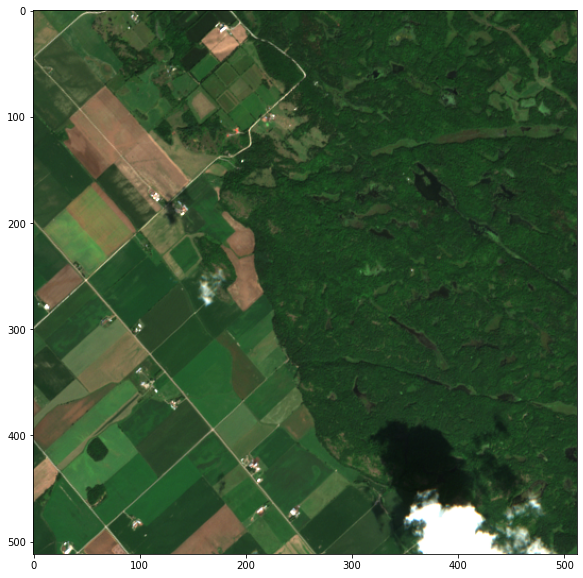

In [ ]:
# show image
fig = plt.figure(figsize=(10,10))
img = rasterio.open("test.tif").read()
img = np.clip(img, 0, 2000)/2000.0
plt.imshow(np.transpose(img, (1,2,0)))

(10, 512, 512)


/content/utils.py:225: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/content/utils.py:226: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


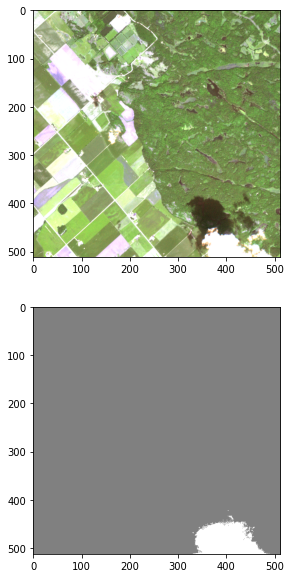

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

#meta needed if we want to save the image
image,meta = utils.tif_to_image(sat_tile, crop=crop) #NOTE no band arg = we load all bands

with rasterio.open("test.tif", 'w', **meta) as dst:
    dst.write(image)

# NOTE: if you have the model stored somewhere else, 
# change the location in utils.infer_image()
res = utils.infer_image(file_path='test.tif', plot=True) #x and y starting point at 5000, were always taking a 512x512 crop

note that for the endpoint you're supposed to create we want the full numpy array back here saved as `res`

In [ ]:
res.shape, res

((512, 512), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

For this example we use a pretrained model that does cloud detection. In this case we use it so its easy for you to run a pretrained ML model without having to know much about the details

## stretch goal
The assignment above is highly simplified. One issue that is left out is the fact that the images we work with are not actually 512 x 512 pixels but up to 30K x 30K for a single satellite tile.

Please see an example of 2 such images here:

Stretch assignment:
- use the code above to create a preprocessing service that slides a window over a satellite tile to run predictions on, after which the patches will have to be aggregated again to a single large satellite tile.

The input for the stretch assigment will be a full satellite tile, rather than a single 512x512 patch